## Doom Reinforcement Learning Model -  Deadly Corridor

### Goal:
Reach armour at the end of the corridor

### Rewards: 
1000 points for armour
1312 maximum for moving towards it

### Challenge:
Cannot just run straight for the armour or he will die from getting shot by monsters

### How to Solve?
#### Reward Shaping
Incentivize our agent to do something by modifying reward function
#### Curriculum Learning
Progressively increase the difficulty of the enviornment to allow the agent 
to learn to initially learn 'good' actions earlier on.

## 1. Prepare Enviorment

In [194]:
# To install viz doom
# !pip install vizdoom

# Clone the VizDoom GitHub repo from this URL
# https://github.com/mwydmuch/ViZDoom

In [195]:
# Import necessary Libraries
import random # allows for action sampling
import time # # allows for sleeping between frames
import numpy as np # import for identity array matrix
from vizdoom import * # import for game enviornment
from matplotlib import pyplot as plt # import for vizualizations

# Setting for display - dont output all 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

In [196]:
game = DoomGame() # Define game
game.load_config('ViZDoom-master/ViZDoom-master/scenarios/deadly_corridor_s1.cfg') # Load Game configuration

## In deadly_configue.cfg -> change to:
# available_game_variables = { HEALTH DAMAGE_TAKEN DAMAGECOUNT SELECTED_WEAPON_AMMO}

## Create with lesser difficultys: deadly_corridor_s1.cfg -> change to:
# doom_skill = 1
# Repeat for skill levels 1 to 5 - allows for curriculum learning

game.init() # Initial Game 

In [197]:
# Set of possible actions in current Doom game enviornment
actions = np.identity(7, dtype=np.uint8)

In [198]:
game.is_episode_finished()

False

In [199]:
game.get_state().screen_buffer.shape

(3, 240, 320)

In [200]:
state = game.get_state()

In [201]:
state.game_variables

array([100.,   0.,   0.,  -1.])

In [202]:
# Loop to run through episodes (basic level) 
# Untrained - Random Actions

episodes = 1 # Play 1 games
for episode in range(episodes):
    game.new_episode() # Start from scratch
    while not game.is_episode_finished(): # Check if game is finished
        state = game.get_state() # Get current frame / game state
        img = state.screen_buffer # Get specific image
        info = state.game_variables # Get info on game state=
        # Take random action and assoicate that with reward 
        # Can add frame skip param to speed up 
        reward = game.make_action(random.choice(actions)) 
        #print('Reward:', reward)
        time.sleep(0.002) # Take brief break before exiting while loop and printing game result
    print('Result:', game.get_total_reward())
    time.sleep(2) # Sleep 2 seconds before next iteration in for loop

Result: -115.81414794921875


In [203]:
game.close()

## 2. Convert game to OpenAI Gym enviornment

In [204]:
from gym import Env # Base class enviornment from OpenAI Gym
from gym.spaces import Discrete, Box # Allows us to define shapes from our enviornments
import cv2 # Allows for computer vision

#### Testing Box and Discrete

In [205]:
Box(low=0, high=10, shape=(10,10), dtype=np.uint8).sample()

array([[ 4,  3,  5,  5,  5, 10,  4,  0,  3,  2],
       [ 6,  7,  4,  0,  8,  5, 10,  8,  4,  8],
       [ 6,  8,  5,  4,  7,  8,  8,  2,  9,  5],
       [ 7,  9,  2,  0,  4,  7,  1,  1,  1,  8],
       [ 3,  0,  8,  0,  4,  9,  2,  3,  6,  6],
       [ 3,  6,  6,  6,  6,  1,  7,  5,  5,  2],
       [ 9,  6,  0,  4,  6,  1,  7,  4,  1,  7],
       [ 4,  3,  6,  2,  6,  2,  8,  7,  1,  1],
       [ 8,  0, 10,  1,  9,  7,  2,  9,  7,  5],
       [10,  9,  5,  6,  5,  8,  9,  8, 10,  1]], dtype=uint8)

In [206]:
Discrete(3).sample()

1

In [207]:
actions[Discrete(3).sample()]

array([0, 0, 1, 0, 0, 0, 0], dtype=uint8)

#### Define vizDoom Enviornment Class

In [223]:
class VizDoomGym(Env):
    
    # Function called at initialization(start) of Env
    def __init__(self, render=False, config='ViZDoom-master/ViZDoom-master/scenarios/deadly_corridor_s1.cfg'):
        # Inherit from Env
        super().__init__()
        # Set up game
        self.game = DoomGame() # Define game
        # Load Game configuration; able to change
        self.game.load_config(config) 
        
        # Define whether or not to render the game - Rendering hinders training speed
        # Render frame logic
        if render == False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        
        # Initial Game (Start Game)
        self.game.init() 
        
        # Create and define observation and activation space for game
        self.observation_space = Box(low=0, high=255, shape=(100,160,1), dtype=np.uint8)
        self.action_space = Discrete(7)
        
        # Game Variables: HEALTH DAMAGE_TAKEN DAMAGECOUNT SLECTED_WEAPON_AMMO
        self.damage_taken = 0
        self.damagecount = 0
        self.ammo = 52
    
    # Function - how we take steps in enviornment
    def step(self, action):
        # Specify action and take step
        actions = np.identity(7, dtype=np.uint8) # Define actions
        movement_reward = self.game.make_action(actions[action], 4) # Define reward based on action
        
        # Define reward variable
        reward = 0
        
        # Get and return relevent game information, variables
        if self.game.get_state(): 
            state = self.game.get_state().screen_buffer # Define current game state
            state = self.grayscale(state) # Apply gray scale to step function
            
            # Reward Shaping
            game_variables = self.game.get_state().game_variables
            health, damage_taken, damagecount, ammo = game_variables # Unpack values
            
            # Calculate reward deltas
            damage_taken_delta = -damage_taken + self.damage_taken
            self.damage_taken = damage_taken
            damagecount_delta = damagecount - self.damagecount
            self.damagecount = damagecount
            ammo_delta = ammo - self.ammo
            self.ammo = ammo
            
            # Calculate reward based off reward deltas
            reward = movement_reward + damage_taken_delta*10 + damagecount_delta*200  + ammo_delta*5
            
            info = ammo
            
        else:
            state = np.zeros(self.observation_space.shape)
            info = 0
        
        info = {"info":info}
        done = self.game.is_episode_finished() # Determine whether game is finsihed
        
        return state, reward, done, info
    
    # Don't need to define render function - predefined in vizDoom
    # Normally, the function to render a game / enviornment
    def render():
        pass
    
    # Function - what happens when new game is started
    def reset(self):
        self.game.new_episode() # Start new game
        state = self.game.get_state().screen_buffer
        return self.grayscale(state) # Apply grayscale to reset function
    
    # Function - grayscale and resize game frame
    def grayscale(self, observation):
        # Concert to grayscale
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        # Resize to remove bottom info bar from game observation
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state
     
    # Function - Call to close down game
    def close(self):
        self.game.close()

#### Test enviornment and return relevant information

In [224]:
env = VizDoomGym(render=False)

In [225]:
res = env.step(5)
res[1]

0.0

In [226]:
env.observation_space.sample().shape

(100, 160, 1)

In [227]:
env.action_space

Discrete(7)

## 3. View State

In [228]:
state = env.reset()

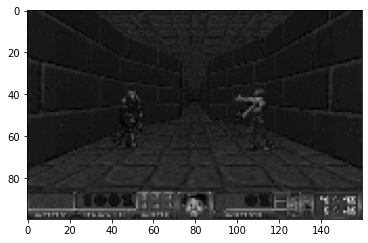

In [229]:
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))

In [230]:
# Import enviornment checker
from stable_baselines3.common import env_checker

In [231]:
# Check for valid env - no error is good
env_checker.check_env(env)

In [232]:
env.close()

## 4. Setup Callback

In [233]:
# import necessary libraries
import os
from stable_baselines3.common.callbacks import BaseCallback

In [234]:
# Define class for training and logging callback
class TrainAndLoggingCallback(BaseCallback):
    
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
            
        return True

In [235]:
# Dirs for saving trained RL models
CHECKPOINT_DIR = './train/train_deadly_corridor'
LOG_DIR = './logs/log_deadly_corridor'

In [236]:
# Create instance of train and logging callback - save pytorch model every 10,000 steps
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

## 5. Train Reinforcement Learning Model - Using Curiculum Learning

In [237]:
# Import ppo for training
from stable_baselines3 import PPO

In [238]:
# Create non rendered enviornment
env = VizDoomGym(config='ViZDoom-master/ViZDoom-master/scenarios/deadly_corridor_s1.cfg')

In [249]:
# Define model and policy 

## Previous model for defend the center
#model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=4096)

## New model for deadly corridor
# Lower learning rate
# Increase batch size (n_steps) - needs to be function of 64
# Add clip range to clip gradient
# Add gamma - discount factor
# Add gae_lambda - smoothing parameter to calculate advantage
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.00001, n_steps=8192,
           clip_range=0.1, gamma=.95, gae_lambda=.9)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [240]:
# Train model for 400k steps - increased from 100k for defend center
model.learn(total_timesteps=400000, callback=callback)

Logging to ./logs/log_deadly_corridor\PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 209      |
|    ep_rew_mean     | 173      |
| time/              |          |
|    fps             | 32       |
|    iterations      | 1        |
|    time_elapsed    | 252      |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 222         |
|    ep_rew_mean          | 189         |
| time/                   |             |
|    fps                  | 28          |
|    iterations           | 2           |
|    time_elapsed         | 571         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.002918135 |
|    clip_fraction        | 0.0925      |
|    clip_range           | 0.1         |
|    entropy_loss         | -1.94       |
|    explained_variance   | 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 129          |
|    ep_rew_mean          | 309          |
| time/                   |              |
|    fps                  | 27           |
|    iterations           | 11           |
|    time_elapsed         | 3273         |
|    total_timesteps      | 90112        |
| train/                  |              |
|    approx_kl            | 0.0034843483 |
|    clip_fraction        | 0.266        |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.9         |
|    explained_variance   | 0.0785       |
|    learning_rate        | 1e-05        |
|    loss                 | 7.94e+05     |
|    n_updates            | 100          |
|    policy_gradient_loss | 0.000718     |
|    value_loss           | 2.01e+05     |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 144          |
|    ep_rew_mean          | 470          |
| time/                   |              |
|    fps                  | 27           |
|    iterations           | 21           |
|    time_elapsed         | 6272         |
|    total_timesteps      | 172032       |
| train/                  |              |
|    approx_kl            | 0.0065805735 |
|    clip_fraction        | 0.329        |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.76        |
|    explained_variance   | 0.198        |
|    learning_rate        | 1e-05        |
|    loss                 | 5.31e+04     |
|    n_updates            | 200          |
|    policy_gradient_loss | 0.00263      |
|    value_loss           | 2.52e+05     |
------------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mea

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | 451         |
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 31          |
|    time_elapsed         | 9330        |
|    total_timesteps      | 253952      |
| train/                  |             |
|    approx_kl            | 0.011159036 |
|    clip_fraction        | 0.306       |
|    clip_range           | 0.1         |
|    entropy_loss         | -1.51       |
|    explained_variance   | 0.288       |
|    learning_rate        | 1e-05       |
|    loss                 | 4.85e+04    |
|    n_updates            | 300         |
|    policy_gradient_loss | 0.00578     |
|    value_loss           | 1.6e+05     |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 268 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 173         |
|    ep_rew_mean          | 183         |
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 41          |
|    time_elapsed         | 12361       |
|    total_timesteps      | 335872      |
| train/                  |             |
|    approx_kl            | 0.007964397 |
|    clip_fraction        | 0.302       |
|    clip_range           | 0.1         |
|    entropy_loss         | -1.34       |
|    explained_variance   | 0.47        |
|    learning_rate        | 1e-05       |
|    loss                 | 1.98e+05    |
|    n_updates            | 400         |
|    policy_gradient_loss | 0.00635     |
|    value_loss           | 1.68e+05    |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 169 

In [257]:
# Pre-load model with weights
model.load('./train/train_deadly_corridor/best_model_400000.zip')

In [266]:
## Fix Curriculum Learning for other skill levels
#env = VizDoomGym(config='ViZDoom-master/ViZDoom-master/scenarios/deadly_corridor_s2.cfg')
#model.set_env(env)
#model.learn(total_timesteps=40000, callback=callback)

## 6. Test Model

In [259]:
# import evaluation policy to test agent
from stable_baselines3.common.evaluation import evaluate_policy
import time

In [260]:
# Reload model from disc drive
model = PPO.load('./train/train_deadly_corridor/best_model_400000')

In [261]:
# Create rendered enviornment
env = VizDoomGym(render=True, config='ViZDoom-master/ViZDoom-master/scenarios/deadly_corridor_s1.cfg')

In [262]:
# Evaluate mean reward for 100 games
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)

C:\Users\Peter\anaconda3\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [263]:
# Display mean reward
mean_reward

285.75463409423827

In [264]:
# Loop to test agent without using evaluate_policy
for episode in range(10): 
    obs = env.reset() # observations
    done = False # havent completed
    total_reward = 0 
    while not done: 
        action, _ = model.predict(obs) # get action
        obs, reward, done, info = env.step(action) # pass into env step function
        #time.sleep(0.20)
        total_reward += reward # update reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))

Total Reward for episode 0 is -2641.2537841796875
Total Reward for episode 1 is 15040.025344848633
Total Reward for episode 2 is -6470.977584838867
Total Reward for episode 3 is -779.1217498779297
Total Reward for episode 4 is -1480.5687255859375
Total Reward for episode 5 is -3738.7269439697266
Total Reward for episode 6 is 9081.021865844727
Total Reward for episode 7 is -3419.8807830810547
Total Reward for episode 8 is -3607.0028533935547
Total Reward for episode 9 is -735.5765533447266


In [265]:
env.close()